In [ ]:
#Important libraries 
import pandas as pd
import sklearn 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Read the csv files and convert to dataframes
url1 = "/content/test.csv"
url2 = "/content/train.csv"
#url3 = "/gender_submission.csv"

test = pd.read_csv(url1)
train = pd.read_csv(url2)

By looking at the data we can quickly see some irrelevant columns: ticket, cabin,passengerId. (these are unlikely to provide any new information)

Here is a quick overview of the columns:

survived: 1=survived/0=didn't
Pclass: Ticket class
sibsp: # of siblings / spouses aboard the Titanic
parch: # of parents / children aboard the Titanic
embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [ ]:
train.columns

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.columns

test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
print(train.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:

drop_columns = ['PassengerId', 'Cabin', 'Ticket']

train.drop(drop_columns, axis = 1, inplace= True)


In [ ]:
test.drop(drop_columns, axis = 1, inplace= True)


In [ ]:
train['Age'].fillna(train['Age'].median(), inplace = True)
test['Age'].fillna(test['Age'].median(), inplace = True)
test['Fare'].fillna(test['Fare'].median(), inplace = True)


print(train['Age'].isnull().sum() == 0)
print(test['Age'].isnull().sum() == 0)
print(test['Fare'].isnull().sum() == 0)

True
True
True


In [ ]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace = True)

print(train['Embarked'].isnull().sum() == 0)
print(test['Embarked'].isnull().sum() == 0)

True
True


In [ ]:
dfs = [train, test]

In [ ]:
replace_titles = {"Mlle": "Miss","Ms": "Miss",'Mme':'Miss' }
for df in dfs:
  df['Title'] = ''
  df['Title'] = df['Name'].str.split(', ',expand=True)[1].str.split('.',expand=True)
  df.replace({'Title':replace_titles},inplace=True)
  rare_titles = df['Title'].value_counts() <10  # titles that are not statistically significant will be grouped together
  df['Title'] =df['Title'].apply(lambda x: 'Other' if rare_titles.loc[x] == True else x)
  df['FareBin'] = pd.qcut (df['Fare'],4) # cut according to equal frequencies 
  df['AgeBin'] = pd.cut(df['Age'].astype('int'),5) # cut into equal intervals

In [ ]:
train['Title'].value_counts()

Mr        517
Miss      186
Mrs       125
Master     40
Other      23
Name: Title, dtype: int64

In [ ]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FareBin,AgeBin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,"(7.91, 14.454]","(16.0, 32.0]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,"(7.91, 14.454]","(32.0, 48.0]"


In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


label = LabelEncoder()

trans_col = ['Sex', 'Title', 'Embarked']

#train['Sex'] = label.fit_transform(train['Sex'])
#train['Title'] = label.fit_transform(train['Title'])
#train['Embarked'] = label.fit_transform(train['Embarked'])
#train['FareBin'] = label.fit_transform(train['FareBin'])
#train['AgeBin'] = label.fit_transform(train['AgeBin'])

In [ ]:
x_dummies = ['Embarked', 'Title', 'Sex', 'SibSp', 'Fare', 'Parch']

for df in dfs:
  for col in x_dummies:
    df[col + '_coded'] = label.fit_transform(df[col])


x_coded = ['Sex_coded','Pclass', 'Embarked_coded', 'Title_coded','SibSp', 'Parch', 'Age', 'Fare']

train[x_coded] ###Use this as the test 
test[x_coded]


,Sex_coded,Pclass,Embarked_coded,Title_coded,SibSp,Parch,Age,Fare
0,1,3,1,2,0,0,34.5,7.8292
1,0,3,2,3,1,0,47.0,7.0000
2,1,2,1,2,0,0,62.0,9.6875
3,1,3,2,2,0,0,27.0,8.6625
4,0,3,2,3,1,1,22.0,12.2875
...,...,...,...,...,...,...,...,...
413,1,3,2,2,0,0,27.0,8.0500
414,0,1,0,4,0,0,39.0,108.9000
415,1,3,2,2,0,0,38.5,7.2500
416,1,3,2,2,0,0,27.0,8.0500


Training the model

In [ ]:
from sklearn import ensemble, svm ,tree, naive_bayes,neighbors,linear_model, discriminant_analysis, gaussian_process
from sklearn import feature_selection, model_selection, metrics
from xgboost import XGBClassifier

MLA =[
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    
    gaussian_process.GaussianProcessClassifier(),
    
    
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    XGBClassifier()
    
]



In [ ]:
# split training data 


cv_split= model_selection.ShuffleSplit(n_splits=10,test_size=0.3,train_size=0.6,random_state=42)

MLA_cols = ['Name','Params', 'Train Accuracy (mean)', 'Test Accuracy (mean)', 'Test_STD_3', 'Time']
MLA_df = pd.DataFrame(columns = MLA_cols)
MLA_predict = train.iloc[:,0]

for row_nb, alg in enumerate(MLA):
    
    MLA_df.loc[row_nb, 'Name'] = alg.__class__.__name__ # algorithm name
    
    
    cv_result = model_selection.cross_validate(alg,train[x_coded],train.iloc[:,0],cv=cv_split,return_train_score=True)
    
    
    MLA_df.loc[row_nb,'Params'] = str(alg.get_params())
    MLA_df.loc[row_nb,'Time'] = cv_result['fit_time'].mean()
    MLA_df.loc[row_nb,'Train Accuracy (mean)'] = cv_result['train_score'].mean()
    MLA_df.loc[row_nb,'Test Accuracy (mean)'] = cv_result['test_score'].mean()
    MLA_df.loc[row_nb,'Test_STD_3'] = cv_result['test_score'].std() * 3
  
    alg.fit(train[x_coded],train.iloc[:,0].values.ravel())
    MLA_predict[alg.__class__.__name__] =alg.predict(train[x_coded])

MLA_df.sort_values(by='Test Accuracy (mean)',inplace=True,ascending=False)
MLA_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMI

,Name,Params,Train Accuracy (mean),Test Accuracy (mean),Test_STD_3,Time
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.916854,0.835448,0.0670615,0.0990977
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.89588,0.830224,0.0434265,0.0338809
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.968352,0.81194,0.0351143,0.0273313
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.848127,0.81194,0.0637569,0.0802666
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.812921,0.809701,0.0602817,0.00218265
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.986891,0.806716,0.056149,0.161076
12,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.796442,0.804478,0.0656928,0.00231228
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.814045,0.798134,0.0586913,0.088664
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.800562,0.797761,0.0487423,0.684751
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.800749,0.797015,0.0498606,0.00435264


In [ ]:
#Determining the correlation

y = train.iloc[:,[0]]

for x in x_coded:
   print("Correlation by: ", x)
   n = train.groupby(x, as_index = False).mean()
   print(n.iloc[:,[0,1]])
   print('_'*15)

Correlation by:  Sex_coded
   Sex_coded  Survived
0          0  0.742038
1          1  0.188908
_______________
Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
_______________
Correlation by:  Embarked_coded
   Embarked_coded  Survived
0               0  0.553571
1               1  0.389610
2               2  0.339009
_______________
Correlation by:  Title_coded
   Title_coded  Survived
0            0  0.575000
1            1  0.704301
2            2  0.156673
3            3  0.792000
4            4  0.347826
_______________
Correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
_______________
Correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
_______________
Correlation by:  Age
      Age 

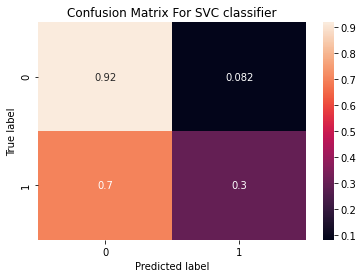

In [ ]:
# Confusion Matrix Example
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = cross_val_predict(svm.SVC(probability=True),train[x_coded],train.iloc[:,0],cv=10)
sns.heatmap(confusion_matrix(train.iloc[:,0],y_pred,normalize='true'),annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix For SVC classifier');

In [ ]:
model = ensemble.GradientBoostingClassifier()
base_results = model_selection.cross_validate(model, train[x_coded],train.iloc[:,0],cv=cv_split)
model.fit(train[x_coded],train.iloc[:,0])

print ('Default params:',model.get_params())
print('Test Score With Default Params:',base_results['test_score'].mean()*100 )
print('STD *3 with Default Params:', base_results['test_score'].std() *300)

print('-'*25)

param_grid = {
    'n_estimators' : [100],
    'max_features' : ['auto'],
    'max_depth': [3],
    'min_samples_split': [2],
    'min_samples_leaf' : [1],

}

tune_model = model_selection.GridSearchCV(model,param_grid=param_grid,cv=cv_split,scoring='roc_auc')
tune_model.fit(train[x_coded],train.iloc[:,0])

print ('Best params:',tune_model.best_params_)
print('Test Score With Default Params:',tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100 )
print('STD *3 with Default Params:', tune_model.cv_results_['std_test_score'][tune_model.best_index_]*300)


#prediction of 'Survived passengers' for the train dataset
train_pred = tune_model.predict(train[x_coded])

#Prediction for test dataset
test_pred = tune_model.predict(test[x_coded]) 


Default params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Test Score With Default Params: 83.47014925373136
STD *3 with Default Params: 6.411941861919261
-------------------------
Best params: {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test Score With Default Params: 87.47092943847781
STD *3 with Default Params: 6.26959495493012


In [ ]:
import pandas as pd
test_pred = pd.DataFrame(test_pred, columns= ['Predicted'])
test_pred


,Predicted
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [ ]:
# Tuning parameters for SVC classifier


model = svm.SVC(probability=True)
base_results = model_selection.cross_validate(model, train[x_coded],train.iloc[:,0],cv=cv_split)
model.fit(train[x_coded],train.iloc[:,0])

print ('Default params:',model.get_params())
print('Test Score With Default Params:',base_results['test_score'].mean()*100 )
print('STD *3 with Default Params:', base_results['test_score'].std() *300)

print('-'*25)


param_grid = {
    'kernel': ['rbf'], # kernel parameters selects the type of hyperplane used to separate the data.
    'gamma': [0.01], # gamma is a parameter for non linear hyperplanes. The higher the gamma value it tries to exactly fit the training data set
    'C': [1], # C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly.
    'degree': [2], #degree is a parameter used when kernel is set to ‘poly’. It’s basically the degree of the polynomial used to find the hyperplane to split the data.
}

tune_model = model_selection.GridSearchCV(model,param_grid=param_grid,cv=cv_split,scoring='roc_auc')
tune_model.fit(train[x_coded],train.iloc[:,0])

print ('Best params:',tune_model.best_params_)
print('Test Score With Default Params:',tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100 )
print('STD *3 with Default Params:', tune_model.cv_results_['std_test_score'][tune_model.best_index_]*300)

Default params: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Test Score With Default Params: 67.16417910447761
STD *3 with Default Params: 8.927194942109054
-------------------------
Best params: {'C': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
Test Score With Default Params: 77.59853663473588
STD *3 with Default Params: 6.74383571188322
